# Load library

In [1]:
#Import lib
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from my_useful_functions import calculate_performance_statistical_parity,calculate_performance_equalized_odds,calculate_performance_equal_opportunity,calculate_performance_predictive_parity,calculate_performance_predictive_equality,calculate_performance_treatment_equality
from sklearn import preprocessing
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
# DT
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
# NB
from sklearn.naive_bayes import GaussianNB
# MLP
from sklearn.neural_network import MLPClassifier
# kNN
from sklearn.neighbors import KNeighborsClassifier
# Adafair
from AdaFair import AdaFair 
# Agarwal
from exponentiated_gradient_reduction import ExponentiatedGradientReduction
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
# DIR
from disparate_impact_remover import DisparateImpactRemover
# LFR
from learning_fair_representations import LFR
# EOP
from eq_odds_postprocessing import EqOddsPostprocessing
# CEP
from calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from compute_abroca import *
import numpy as np
import sklearn.metrics as metrics 
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[LawSchoolGPA]'
2023-03-27 11:06:08.519379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 11:06:08.519395: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Dataset

## German Credit

In [2]:
def load_german_credit():
    df = pd.read_csv('data/german_data_credit.csv')    
    protected_attribute = 'sex'
    majority_group_name = "male"
    minority_group_name = "female"
    class_label = 'class-label' 
    
    print("Length:",len(df))
    print("Number of attribute:",len(df.columns))
    
    print("Length (cleaned):",len(df))
    print("Class imbalance: \n",df[class_label].value_counts())
    #label encode
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,:length-1]
    y = df[class_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X_train, X_test, y_train, y_test,sa_index, p_Group, protected_attribute,majority_group_name,minority_group_name

# Run experiment

In [3]:
def run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):    
    datasetTrain = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
    datasetTest = BinaryLabelDataset(df=pd.concat([X_test, y_test.to_frame()], axis=1), label_names=[y_test.name], protected_attribute_names=[protected_attribute])
    
    # preprocessing
    if preprocessing_algorithm != '': 
        if preprocessing_algorithm == 'DIR':
            pre_model = DisparateImpactRemover(sensitive_attribute=protected_attribute)
        elif preprocessing_algorithm == 'LFR':
            privileged_groups = [{protected_attribute: 1.0}]
            unprivileged_groups = [{protected_attribute: 0.0}]
            pre_model = LFR(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
        dataset_train_transf = pre_model.fit_transform(datasetTrain)
        dataset_test_transf = pre_model.transform(datasetTest)

        X_train_transf = dataset_train_transf.features
        y_train_transf = dataset_train_transf.labels.ravel()
        X_test_transf = dataset_test_transf.features
        y_test_transf= dataset_test_transf.labels.ravel()

        X_train_transf = pd.DataFrame(X_train_transf, columns = X_train.columns)
        y_train_transf = pd.Series(y_train_transf, name = y_train.name).astype(int)
        X_test_transf = pd.DataFrame(X_test_transf, columns = X_train.columns)
        y_test_transf = pd.Series(y_test_transf, name = y_train.name).astype(int)
    
    # inprocessing
    if algorithm == 'DT':
        model = tree.DecisionTreeClassifier(random_state=0)  
    elif algorithm == 'NB': 
        model = GaussianNB()
    elif algorithm == 'MLP':
        model = MLPClassifier(random_state=1, max_iter=300)
    elif algorithm == 'kNN':
        model = KNeighborsClassifier(n_neighbors=5)
    elif algorithm == 'Ada':
        model = AdaFair(n_estimators=50, saIndex=sa_index, saValue=p_Group, CSB="CSB2", c=1, use_validation=False)
    elif algorithm == 'Agar':
        clf =  NB = GaussianNB()
        model = ExponentiatedGradientReduction(prot_attr=protected_attribute,estimator=clf, constraints = "EqualizedOdds")
    
    if preprocessing_algorithm != '':
        model.fit(X_train_transf, y_train_transf)
        y_predicts = model.predict(X_test_transf)
    else:
        model.fit(X_train,y_train)
        y_predicts = model.predict(X_test)

    # postprocessing
    if postprocessing_algorithm != '':
        privileged_groups = [{protected_attribute: 1.0}]
        unprivileged_groups = [{protected_attribute: 0.0}]
        if postprocessing_algorithm == 'EOP':
            post_model = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        if postprocessing_algorithm == 'CEP':
            post_model = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        
        y_test_predicts = model.predict(X_test)
        y_train_predicts = model.predict(X_train)

        X_train_predicts = X_train.copy()
        X_test_predicts = X_test.copy()

        X_train_predicts[y_train.name] = y_train_predicts
        X_test_predicts[y_train.name] = y_test_predicts
    
        dataset_train_true = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_train_predicts = BinaryLabelDataset(df=X_train_predicts, label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_test_predicts = BinaryLabelDataset(df=X_test_predicts, label_names=[y_test.name], protected_attribute_names=[protected_attribute])

        post_model.fit_predict(dataset_true=dataset_train_true, dataset_pred=dataset_train_predicts)
        dataset_predicts_transf = post_model.predict(dataset_test_predicts)
        data_predicts = dataset_predicts_transf.convert_to_dataframe()[0]
        y_predicts = data_predicts[y_test.name].astype(int)

    print("Statistical parity:")
    print(calculate_performance_statistical_parity(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Equal opportunity")
    print(calculate_performance_equal_opportunity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Equalized odds")
    print(calculate_performance_equalized_odds(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Predictive parity")
    print(calculate_performance_predictive_parity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Predictive equality")
    print(calculate_performance_predictive_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Treatment equality")
    print(calculate_performance_treatment_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    filename = '{}.{}.abroca.pdf'.format(dataset, preprocessing_algorithm+algorithm)
    #make predictions
    if postprocessing_algorithm == '':
        if preprocessing_algorithm:
            X_test['pred_proba'] = model.predict_proba(X_test_transf)[:,1:2]
        else:
            X_test['pred_proba'] = model.predict_proba(X_test)[:,1:2]
        X_test['true_label'] = y_test
        df_test = X_test

        #Compute Abroca
        slice = compute_abroca(df_test, pred_col = 'pred_proba' , label_col = 'true_label', protected_attr_col = protected_attribute,
                            majority_protected_attr_val = 1, n_grid = 10000,
                            plot_slices = True, majority_group_name=majority_group_name ,minority_group_name=minority_group_name,file_name = filename)
        print("ABROCA:",slice)
        plt.clf() 
    plt.clf() 
    

In [4]:
#Main function
def run_eval(dataset, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):
    if dataset == 'credit-approval':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_approval()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'credit-card':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_card()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'german-credit':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_german_credit()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                            
    if dataset == 'PAKDD':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_PAKDD2010()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                
    if dataset == 'credit-scoring':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_scoring()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                        
    if dataset == 'application':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_application()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                       

## German Credit


Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.6566666666666666, 'f1-score': 0.7529976019184652, 'fairness': 0.04845626072041165}
Equal opportunity
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.6566666666666666, 'f1-score': 0.7529976019184652, 'fairness': 0.016045197740112926, 'TPR_protected': 0.7627118644067796, 'TPR_non_protected': 0.7466666666666667, 'TNR_protected': 0.5517241379310345, 'TNR_non_protected': 0.3870967741935484}
Equalized odds
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.6566666666666666, 'f1-score': 0.7529976019184652, 'fairness': 0.18067256147759903, 'TPR_protected': 0.7627118644067796, 'TPR_non_protected': 0.7466666666666667, 'TNR_protected': 0.5517241379310345, 'TNR_non_protected': 0.3870967741935484}
Predictive parity
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.65666666666666

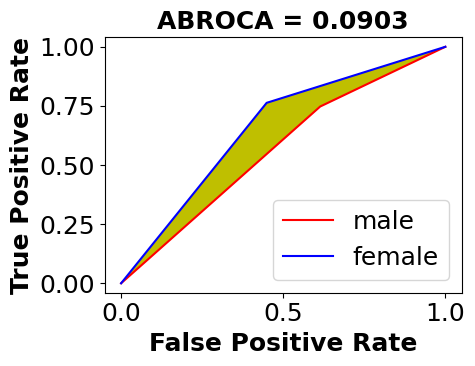

ABROCA: 0.09033628007002462


<Figure size 640x480 with 0 Axes>

In [5]:
run_eval(dataset='german-credit', algorithm='DT')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6604185288395815, 'accuracy': 0.73, 'f1-score': 0.8120649651972159, 'fairness': 0.0019296740994854122}
Equal opportunity
{'balanced_accuracy': 0.6604185288395815, 'accuracy': 0.73, 'f1-score': 0.8120649651972159, 'fairness': 0.06135593220338986, 'TPR_protected': 0.8813559322033898, 'TPR_non_protected': 0.82, 'TNR_protected': 0.5517241379310345, 'TNR_non_protected': 0.45161290322580644}
Equalized odds
{'balanced_accuracy': 0.6604185288395815, 'accuracy': 0.73, 'f1-score': 0.8120649651972159, 'fairness': 0.1614671669086179, 'TPR_protected': 0.8813559322033898, 'TPR_non_protected': 0.82, 'TNR_protected': 0.5517241379310345, 'TNR_non_protected': 0.45161290322580644}
Predictive parity
{'balanced_accuracy': 0.6604185288395815, 'accuracy': 0.73, 'f1-score': 0.8120649651972159, 'fairness': 0.016560509554140124, 'TPR_protect

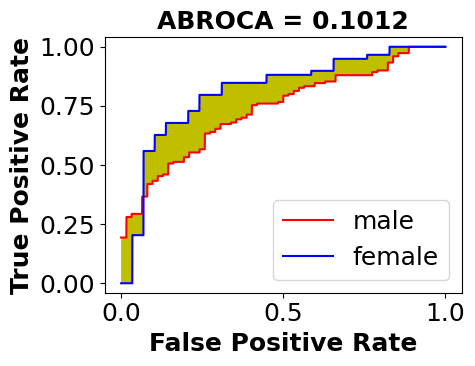

ABROCA: 0.10122308997685432


<Figure size 640x480 with 0 Axes>

In [6]:
run_eval(dataset='german-credit', algorithm='NB')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6094694778905305, 'accuracy': 0.6633333333333333, 'f1-score': 0.75544794188862, 'fairness': -0.06689536878216129}
Equal opportunity
{'balanced_accuracy': 0.6094694778905305, 'accuracy': 0.6633333333333333, 'f1-score': 0.75544794188862, 'fairness': 0.09355932203389838, 'TPR_protected': 0.8135593220338984, 'TPR_non_protected': 0.72, 'TNR_protected': 0.4482758620689655, 'TNR_non_protected': 0.4838709677419355}
Equalized odds
{'balanced_accuracy': 0.6094694778905305, 'accuracy': 0.6633333333333333, 'f1-score': 0.75544794188862, 'fairness': 0.12915442770686836, 'TPR_protected': 0.8135593220338984, 'TPR_non_protected': 0.72, 'TNR_protected': 0.4482758620689655, 'TNR_non_protected': 0.4838709677419355}
Predictive parity
{'balanced_accuracy': 0.6094694778905305, 'accuracy': 0.6633333333333333, 'f1-score': 0.75544794188862, 

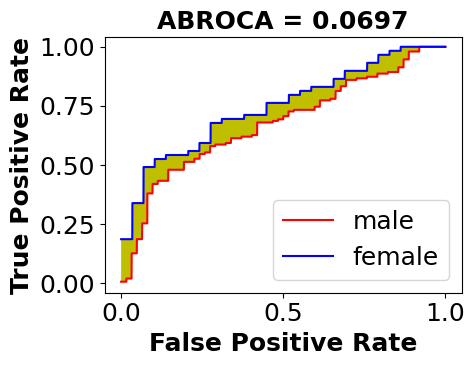

ABROCA: 0.06972757433742914


<Figure size 640x480 with 0 Axes>

In [7]:
run_eval(dataset='german-credit', algorithm='MLP')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5347547189652453, 'accuracy': 0.65, 'f1-score': 0.7671840354767183, 'fairness': 0.06410806174957118}
Equal opportunity
{'balanced_accuracy': 0.5347547189652453, 'accuracy': 0.65, 'f1-score': 0.7671840354767183, 'fairness': 0.0670056497175141, 'TPR_protected': 0.7796610169491526, 'TPR_non_protected': 0.8466666666666667, 'TNR_protected': 0.27586206896551724, 'TNR_non_protected': 0.22580645161290322}
Equalized odds
{'balanced_accuracy': 0.5347547189652453, 'accuracy': 0.65, 'f1-score': 0.7671840354767183, 'fairness': 0.11706126707012812, 'TPR_protected': 0.7796610169491526, 'TPR_non_protected': 0.8466666666666667, 'TNR_protected': 0.27586206896551724, 'TNR_non_protected': 0.22580645161290322}
Predictive parity
{'balanced_accuracy': 0.5347547189652453, 'accuracy': 0.65, 'f1-score': 0.7671840354767183, 'fairness': 0.0391

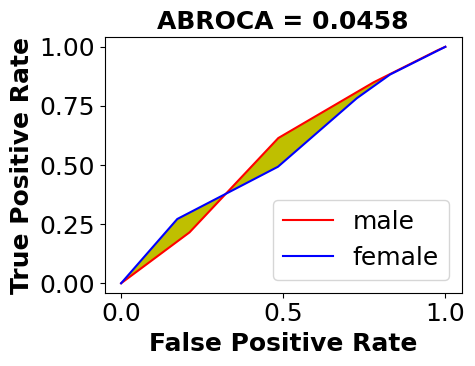

ABROCA: 0.04580839057032602


<Figure size 640x480 with 0 Axes>

In [8]:
run_eval(dataset='german-credit', algorithm='kNN')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.037092624356775294, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.69

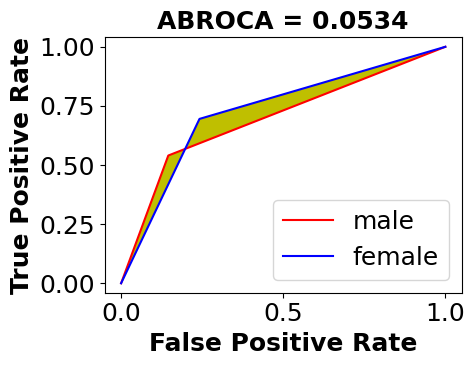

ABROCA: 0.05343922204798221


<Figure size 640x480 with 0 Axes>

In [9]:
run_eval(dataset='german-credit', algorithm='Ada')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6398601398601399, 'accuracy': 0.71, 'f1-score': 0.7972027972027972, 'fairness': -0.13614922813036023}
Equal opportunity
{'balanced_accuracy': 0.6398601398601399, 'accuracy': 0.71, 'f1-score': 0.7972027972027972, 'fairness': 0.15887005649717512, 'TPR_protected': 0.9322033898305084, 'TPR_non_protected': 0.7733333333333333, 'TNR_protected': 0.3793103448275862, 'TNR_non_protected': 0.5}
Equalized odds
{'balanced_accuracy': 0.6398601398601399, 'accuracy': 0.71, 'f1-score': 0.7972027972027972, 'fairness': 0.27955971166958893, 'TPR_protected': 0.9322033898305084, 'TPR_non_protected': 0.7733333333333333, 'TNR_protected': 0.3793103448275862, 'TNR_non_protected': 0.5}
Predictive parity
{'balanced_accuracy': 0.6398601398601399, 'accuracy': 0.71, 'f1-score': 0.7972027972027972, 'fairness': 0.0356909887242568, 'TPR_protected': 0

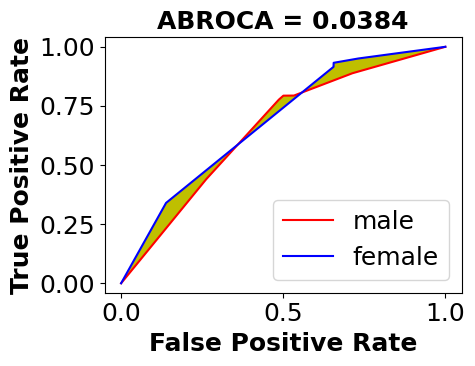

ABROCA: 0.03843081603131325


<Figure size 640x480 with 0 Axes>

In [10]:
run_eval(dataset='german-credit', algorithm='Agar')

In [11]:
run_eval(dataset='german-credit', algorithm='DT', preprocessing_algorithm='DIR')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6221410168778589, 'accuracy': 0.6766666666666666, 'f1-score': 0.7662650602409637, 'fairness': -0.07354202401372212}
Equal opportunity
{'balanced_accuracy': 0.6221410168778589, 'accuracy': 0.6766666666666666, 'f1-score': 0.7662650602409637, 'fairness': 0.09717514124293791, 'TPR_protected': 0.8305084745762712, 'TPR_non_protected': 0.7333333333333333, 'TNR_protected': 0.4482758620689655, 'TNR_non_protected': 0.5}
Equalized odds
{'balanced_accuracy': 0.6221410168778589, 'accuracy': 0.6766666666666666, 'f1-score': 0.7662650602409637, 'fairness': 0.1488992791739724, 'TPR_protected': 0.8305084745762712, 'TPR_non_protected': 0.7333333333333333, 'TNR_protected': 0.4482758620689655, 'TNR_non_protected': 0.5}
Predictive parity
{'balanced_accuracy': 0.6221410168778589, 'accuracy': 0.6766666666666666, 'f1-score': 0.7662650602409

In [12]:
run_eval(dataset='german-credit', algorithm='NB', preprocessing_algorithm='DIR')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6391503233608496, 'accuracy': 0.7133333333333334, 'f1-score': 0.8009259259259259, 'fairness': -0.009433962264150941}
Equal opportunity
{'balanced_accuracy': 0.6391503233608496, 'accuracy': 0.7133333333333334, 'f1-score': 0.8009259259259259, 'fairness': 0.051073446327683625, 'TPR_protected': 0.864406779661017, 'TPR_non_protected': 0.8133333333333334, 'TNR_protected': 0.4827586206896552, 'TNR_non_protected': 0.43548387096774194}
Equalized odds
{'balanced_accuracy': 0.6391503233608496, 'accuracy': 0.7133333333333334, 'f1-score': 0.8009259259259259, 'fairness': 0.09834819604959688, 'TPR_protected': 0.864406779661017, 'TPR_non_protected': 0.8133333333333334, 'TNR_protected': 0.4827586206896552, 'TNR_non_protected': 0.43548387096774194}
Predictive parity
{'balanced_accuracy': 0.6391503233608496, 'accuracy': 0.713333333333

In [13]:
run_eval(dataset='german-credit', algorithm='MLP', preprocessing_algorithm='DIR')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5675377254324623, 'accuracy': 0.7, 'f1-score': 0.8076923076923076, 'fairness': -0.032590051457976}
Equal opportunity
{'balanced_accuracy': 0.5675377254324623, 'accuracy': 0.7, 'f1-score': 0.8076923076923076, 'fairness': 0.062485875706214666, 'TPR_protected': 0.9491525423728814, 'TPR_non_protected': 0.8866666666666667, 'TNR_protected': 0.2413793103448276, 'TNR_non_protected': 0.22580645161290322}
Equalized odds
{'balanced_accuracy': 0.5675377254324623, 'accuracy': 0.7, 'f1-score': 0.8076923076923076, 'fairness': 0.07805873443813904, 'TPR_protected': 0.9491525423728814, 'TPR_non_protected': 0.8866666666666667, 'TNR_protected': 0.2413793103448276, 'TNR_non_protected': 0.22580645161290322}
Predictive parity
{'balanced_accuracy': 0.5675377254324623, 'accuracy': 0.7, 'f1-score': 0.8076923076923076, 'fairness': 0.016857911

In [14]:
run_eval(dataset='german-credit', algorithm='kNN', preprocessing_algorithm='DIR')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.511803985488196, 'accuracy': 0.6266666666666667, 'f1-score': 0.7500000000000001, 'fairness': -0.014365351629502476}
Equal opportunity
{'balanced_accuracy': 0.511803985488196, 'accuracy': 0.6266666666666667, 'f1-score': 0.7500000000000001, 'fairness': 0.060790960451977405, 'TPR_protected': 0.847457627118644, 'TPR_non_protected': 0.7866666666666666, 'TNR_protected': 0.27586206896551724, 'TNR_non_protected': 0.1935483870967742}
Equalized odds
{'balanced_accuracy': 0.511803985488196, 'accuracy': 0.6266666666666667, 'f1-score': 0.7500000000000001, 'fairness': 0.14310464232072045, 'TPR_protected': 0.847457627118644, 'TPR_non_protected': 0.7866666666666666, 'TNR_protected': 0.27586206896551724, 'TNR_non_protected': 0.1935483870967742}
Predictive parity
{'balanced_accuracy': 0.511803985488196, 'accuracy': 0.6266666666666667

In [16]:
run_eval(dataset='german-credit', algorithm='DT', preprocessing_algorithm='LFR')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5331510594668489, 'accuracy': 0.6866666666666666, 'f1-score': 0.8041666666666667, 'fairness': -0.05638936535162953}
Equal opportunity
{'balanced_accuracy': 0.5331510594668489, 'accuracy': 0.6866666666666666, 'f1-score': 0.8041666666666667, 'fairness': 0.059435028248587596, 'TPR_protected': 0.9661016949152542, 'TPR_non_protected': 0.9066666666666666, 'TNR_protected': 0.10344827586206896, 'TNR_non_protected': 0.16129032258064516}
Equalized odds
{'balanced_accuracy': 0.5331510594668489, 'accuracy': 0.6866666666666666, 'f1-score': 0.8041666666666667, 'fairness': 0.11727707496716379, 'TPR_protected': 0.9661016949152542, 'TPR_non_protected': 0.9066666666666666, 'TNR_protected': 0.10344827586206896, 'TNR_non_protected': 0.16129032258064516}
Predictive parity
{'balanced_accuracy': 0.5331510594668489, 'accuracy': 0.686666666

In [17]:
run_eval(dataset='german-credit', algorithm='NB', preprocessing_algorithm='LFR')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5057574004942426, 'accuracy': 0.32, 'f1-score': 0.06422018348623854, 'fairness': -0.021869639794168096}
Equal opportunity
{'balanced_accuracy': 0.5057574004942426, 'accuracy': 0.32, 'f1-score': 0.06422018348623854, 'fairness': 0.0005649717514124297, 'TPR_protected': 0.03389830508474576, 'TPR_non_protected': 0.03333333333333333, 'TNR_protected': 0.9310344827586207, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5057574004942426, 'accuracy': 0.32, 'f1-score': 0.06422018348623854, 'fairness': 0.06953048899279177, 'TPR_protected': 0.03389830508474576, 'TPR_non_protected': 0.03333333333333333, 'TNR_protected': 0.9310344827586207, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5057574004942426, 'accuracy': 0.32, 'f1-score': 0.06422018348623854, 'fairness': 0.5, 'TPR_protected': 0.033

In [18]:
run_eval(dataset='german-credit', algorithm='MLP', preprocessing_algorithm='LFR')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.037092624356775294, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.69

In [22]:
run_eval(dataset='german-credit', algorithm='kNN', preprocessing_algorithm='LFR')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.4950838635049162, 'accuracy': 0.4866666666666667, 'f1-score': 0.5625, 'fairness': 0.14386792452830188}
Equal opportunity
{'balanced_accuracy': 0.4950838635049162, 'accuracy': 0.4866666666666667, 'f1-score': 0.5625, 'fairness': 0.11683615819209042, 'TPR_protected': 0.3898305084745763, 'TPR_non_protected': 0.5066666666666667, 'TNR_protected': 0.6551724137931034, 'TNR_non_protected': 0.45161290322580644}
Equalized odds
{'balanced_accuracy': 0.4950838635049162, 'accuracy': 0.4866666666666667, 'f1-score': 0.5625, 'fairness': 0.3203956687593874, 'TPR_protected': 0.3898305084745763, 'TPR_non_protected': 0.5066666666666667, 'TNR_protected': 0.6551724137931034, 'TNR_non_protected': 0.45161290322580644}
Predictive parity
{'balanced_accuracy': 0.4950838635049162, 'accuracy': 0.4866666666666667, 'f1-score': 0.5625, 'fairness': 

In [23]:
run_eval(dataset='german-credit', algorithm='DT', postprocessing_algorithm='EOP')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.6566666666666666, 'f1-score': 0.7529976019184652, 'fairness': 0.04845626072041165}
Equal opportunity
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.6566666666666666, 'f1-score': 0.7529976019184652, 'fairness': 0.016045197740112926, 'TPR_protected': 0.7627118644067796, 'TPR_non_protected': 0.7466666666666667, 'TNR_protected': 0.5517241379310345, 'TNR_non_protected': 0.3870967741935484}
Equalized odds
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.6566666666666666, 'f1-score': 0.7529976019184652, 'fairness': 0.18067256147759903, 'TPR_protected': 0.7627118644067796, 'TPR_non_protected': 0.7466666666666667, 'TNR_protected': 0.5517241379310345, 'TNR_non_protected': 0.3870967741935484}
Predictive parity
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.65666666666666

In [24]:
run_eval(dataset='german-credit', algorithm='NB', postprocessing_algorithm='EOP')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6286082338713918, 'accuracy': 0.69, 'f1-score': 0.7790973871733966, 'fairness': -0.09348198970840482}
Equal opportunity
{'balanced_accuracy': 0.6286082338713918, 'accuracy': 0.69, 'f1-score': 0.7790973871733966, 'fairness': 0.1346892655367231, 'TPR_protected': 0.8813559322033898, 'TPR_non_protected': 0.7466666666666667, 'TNR_protected': 0.4482758620689655, 'TNR_non_protected': 0.4838709677419355}
Equalized odds
{'balanced_accuracy': 0.6286082338713918, 'accuracy': 0.69, 'f1-score': 0.7790973871733966, 'fairness': 0.1702843712096931, 'TPR_protected': 0.8813559322033898, 'TPR_non_protected': 0.7466666666666667, 'TNR_protected': 0.4482758620689655, 'TNR_non_protected': 0.4838709677419355}
Predictive parity
{'balanced_accuracy': 0.6286082338713918, 'accuracy': 0.69, 'f1-score': 0.7790973871733966, 'fairness': 0.01307189

In [25]:
run_eval(dataset='german-credit', algorithm='MLP', postprocessing_algorithm='EOP')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5991902834008097, 'accuracy': 0.6533333333333333, 'f1-score': 0.7475728155339806, 'fairness': -0.08769296740994859}
Equal opportunity
{'balanced_accuracy': 0.5991902834008097, 'accuracy': 0.6533333333333333, 'f1-score': 0.7475728155339806, 'fairness': 0.10689265536723169, 'TPR_protected': 0.8135593220338984, 'TPR_non_protected': 0.7066666666666667, 'TNR_protected': 0.41379310344827586, 'TNR_non_protected': 0.4838709677419355}
Equalized odds
{'balanced_accuracy': 0.5991902834008097, 'accuracy': 0.6533333333333333, 'f1-score': 0.7475728155339806, 'fairness': 0.17697051966089133, 'TPR_protected': 0.8135593220338984, 'TPR_non_protected': 0.7066666666666667, 'TNR_protected': 0.41379310344827586, 'TNR_non_protected': 0.4838709677419355}
Predictive parity
{'balanced_accuracy': 0.5991902834008097, 'accuracy': 0.653333333333

In [26]:
run_eval(dataset='german-credit', algorithm='kNN', postprocessing_algorithm='EOP')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5309427414690573, 'accuracy': 0.6533333333333333, 'f1-score': 0.7719298245614034, 'fairness': 0.08769296740994859}
Equal opportunity
{'balanced_accuracy': 0.5309427414690573, 'accuracy': 0.6533333333333333, 'f1-score': 0.7719298245614034, 'fairness': 0.08700564971751412, 'TPR_protected': 0.7796610169491526, 'TPR_non_protected': 0.8666666666666667, 'TNR_protected': 0.27586206896551724, 'TNR_non_protected': 0.1935483870967742}
Equalized odds
{'balanced_accuracy': 0.5309427414690573, 'accuracy': 0.6533333333333333, 'f1-score': 0.7719298245614034, 'fairness': 0.16931933158625717, 'TPR_protected': 0.7796610169491526, 'TPR_non_protected': 0.8666666666666667, 'TNR_protected': 0.27586206896551724, 'TNR_non_protected': 0.1935483870967742}
Predictive parity
{'balanced_accuracy': 0.5309427414690573, 'accuracy': 0.6533333333333

In [27]:
run_eval(dataset='german-credit', algorithm='DT', postprocessing_algorithm='CEP')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.6566666666666666, 'f1-score': 0.7529976019184652, 'fairness': 0.04845626072041165}
Equal opportunity
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.6566666666666666, 'f1-score': 0.7529976019184652, 'fairness': 0.016045197740112926, 'TPR_protected': 0.7627118644067796, 'TPR_non_protected': 0.7466666666666667, 'TNR_protected': 0.5517241379310345, 'TNR_non_protected': 0.3870967741935484}
Equalized odds
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.6566666666666666, 'f1-score': 0.7529976019184652, 'fairness': 0.18067256147759903, 'TPR_protected': 0.7627118644067796, 'TPR_non_protected': 0.7466666666666667, 'TNR_protected': 0.5517241379310345, 'TNR_non_protected': 0.3870967741935484}
Predictive parity
{'balanced_accuracy': 0.5953783059046217, 'accuracy': 0.65666666666666

In [28]:
run_eval(dataset='german-credit', algorithm='NB', postprocessing_algorithm='CEP')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6153057468846943, 'accuracy': 0.7233333333333334, 'f1-score': 0.8175824175824176, 'fairness': 0.11513722126929671}
Equal opportunity
{'balanced_accuracy': 0.6153057468846943, 'accuracy': 0.7233333333333334, 'f1-score': 0.8175824175824176, 'fairness': 0.011977401129943499, 'TPR_protected': 0.8813559322033898, 'TPR_non_protected': 0.8933333333333333, 'TNR_protected': 0.5517241379310345, 'TNR_non_protected': 0.24193548387096775}
Equalized odds
{'balanced_accuracy': 0.6153057468846943, 'accuracy': 0.7233333333333334, 'f1-score': 0.8175824175824176, 'fairness': 0.3217660551900102, 'TPR_protected': 0.8813559322033898, 'TPR_non_protected': 0.8933333333333333, 'TNR_protected': 0.5517241379310345, 'TNR_non_protected': 0.24193548387096775}
Predictive parity
{'balanced_accuracy': 0.6153057468846943, 'accuracy': 0.7233333333333

In [29]:
run_eval(dataset='german-credit', algorithm='MLP', postprocessing_algorithm='CEP')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5667490404332509, 'accuracy': 0.66, 'f1-score': 0.7671232876712328, 'fairness': 0.05102915951972553}
Equal opportunity
{'balanced_accuracy': 0.5667490404332509, 'accuracy': 0.66, 'f1-score': 0.7671232876712328, 'fairness': 0.013559322033898313, 'TPR_protected': 0.8135593220338984, 'TPR_non_protected': 0.8, 'TNR_protected': 0.4482758620689655, 'TNR_non_protected': 0.27419354838709675}
Equalized odds
{'balanced_accuracy': 0.5667490404332509, 'accuracy': 0.66, 'f1-score': 0.7671232876712328, 'fairness': 0.18764163571576709, 'TPR_protected': 0.8135593220338984, 'TPR_non_protected': 0.8, 'TNR_protected': 0.4482758620689655, 'TNR_non_protected': 0.27419354838709675}
Predictive parity
{'balanced_accuracy': 0.5667490404332509, 'accuracy': 0.66, 'f1-score': 0.7671232876712328, 'fairness': 0.022727272727272707, 'TPR_protected

In [30]:
run_eval(dataset='german-credit', algorithm='kNN', postprocessing_algorithm='CEP')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5257111309742889, 'accuracy': 0.6633333333333333, 'f1-score': 0.7837259100642399, 'fairness': 0.1395797598627787}
Equal opportunity
{'balanced_accuracy': 0.5257111309742889, 'accuracy': 0.6633333333333333, 'f1-score': 0.7837259100642399, 'fairness': 0.13367231638418076, 'TPR_protected': 0.7796610169491526, 'TPR_non_protected': 0.9133333333333333, 'TNR_protected': 0.27586206896551724, 'TNR_non_protected': 0.12903225806451613}
Equalized odds
{'balanced_accuracy': 0.5257111309742889, 'accuracy': 0.6633333333333333, 'f1-score': 0.7837259100642399, 'fairness': 0.28050212728518187, 'TPR_protected': 0.7796610169491526, 'TPR_non_protected': 0.9133333333333333, 'TNR_protected': 0.27586206896551724, 'TNR_non_protected': 0.12903225806451613}
Predictive parity
{'balanced_accuracy': 0.5257111309742889, 'accuracy': 0.663333333333